In [ ]:
!pip install transformers
!pip install sentencepiece

In [ ]:
import pandas as pd
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import urllib.request
import zipfile
url = 'https://gitlab.com/shimorina/webnlg-dataset/-/archive/master/webnlg-dataset-master.zip?path=release_v3.0/en'
urllib.request.urlretrieve(url, 'webNLG_v3.0.zip')
with zipfile.ZipFile('webNLG_v3.0.zip', 'r') as zip_ref:
    zip_ref.extractall('webNLG_v3.0')

In [ ]:
import glob
import os
import re
import xml.etree.ElementTree as ET

In [ ]:
myDict = {}
special = {'á' : 'a','Á':'A','à':'a','À':'A','â':'a','Â': 'A','ä':'a','Ä':'A','ã':'a','Ã':'A','å':'a','Å':'A','æ':'ae','Æ':'Ae',
           'ç':'c','Ç':'C','é':'e','É':'E','è':'e','È':'E','ê':'e','Ê':'E','ë':'e','Ë':'E','í':'i','Í':'I','ì':'i','Ì':'I','î':'i','Î':'I','ï':'i','Ï':'I', 'İ':'I',
           'ñ':'n','Ñ':'N','ó':'o','Ó':'O','ò':'o','Ò':'O','ô':'o','Ô':'O','ö':'o','õ':'o','Õ':'O','ø':'o','œ':'oe','ß':'B','Ú':'U','ù':'u','Ù':'U','û':'u','Û':'U','ü':'u','Ü':'U', 'ú':'u'}


In [ ]:
def removeSpecial(text):
    wordList = text.split()
    for j in range(len(wordList)):
        temp = wordList[j]
        add = False
        for i in range(len(wordList[j])):
            if wordList[j][i] in special:
                add = True
                wordList[j] = wordList[j].replace(wordList[j][i], special[wordList[j][i]])
        if add == True:
            myDict[wordList[j]] = temp

    no_special = " ".join(wordList)
    return no_special

def addSpecial(text):
    result = ""
    wordList = text.split()
    for word in wordList:
        if word in myDict:
            result += myDict[word]
        elif word + ',' in myDict:
            result += myDict[word] + ','
        elif word + '.' in myDict:
            result += myDict[word] + '.'
        elif word[-1] == '.' and word[:-1] in myDict:
            result += myDict[word[:-1]] + '.'
        elif word[-1] == ',' and word[:-1] in myDict:
            result += myDict[word[:-1]] + ','
        else:
            result += word
        result += ' '
    return result

In [ ]:
files = glob.glob('/content/webNLG_v3.0/webnlg-dataset-master-release_v3.0-en/release_v3.0/en/train/**/*.xml', recursive=True)
triple_re=re.compile('(\d)triples')
data={}
for file in files:
    tree = ET.parse(file)
    root = tree.getroot()
    triples_num=int(triple_re.findall(file)[0])
    for sub_root in root:
        for subsub_root in sub_root:
            lexf=[]
            trpl=[]
            for entry in subsub_root:
              trpl.append(entry.text)
              lex=[triple.text for triple in entry]
              lexf.extend(lex)
            trpl=[i for i in trpl if i.replace('\n','').strip()!='' ]
            lexf=lexf[-triples_num:]
            lexf_str=(' && ').join(lexf)
            data[lexf_str]=trpl

dct={"input_text":[], "target_text":[]}
for st,unst in data.items():
    for i in unst:
        dct['input_text'].append(removeSpecial(st))
        dct['target_text'].append(removeSpecial(i))

train=pd.DataFrame(dct)
train.head()


,input_text,target_text
0,11th_Mississippi_Infantry_Monument | country |...,The 11th Mississippi Infantry monument was com...
1,11th_Mississippi_Infantry_Monument | country |...,The 11th Mississippi Infantry Monument was ere...
2,11th_Mississippi_Infantry_Monument | country |...,The 11th Mississippi Infantry Monument was est...
3,11th_Mississippi_Infantry_Monument | country |...,The 11th Mississippi Infantry Monument is plac...
4,11th_Mississippi_Infantry_Monument | country |...,The 11th Mississippi Infantry Monument is loca...


In [ ]:
train=train.sample(frac=1)
train.to_csv("train.csv")
train.head()

,input_text,target_text
28051,Aaron_Boogaard | height | 1.905 && Aaron_Booga...,Aaron Boogaard was born in Saskatchewan and is...
7048,1001_Gaussia | absoluteMagnitude | 9.7,1001 Gaussia has an absolute magnitude of 9.7.
19545,"A_Long_Long_Way | isbnNumber | ""0-670-03380-4""...",The ISBN number of the hardcover A Long Long W...
14878,AEK_Athens_F.C. | league | Superleague_Greece ...,Olympiacos F.C. were past champions in the Gre...
22244,11th_Mississippi_Infantry_Monument | country |...,The 11th Mississippi Infantry Monument stands ...


In [ ]:
files = glob.glob('/content/webNLG_v3.0/webnlg-dataset-master-release_v3.0-en/release_v3.0/en/dev/**/*.xml', recursive=True)
triple_re=re.compile('(\d)triples')
data={}
for file in files:
    tree = ET.parse(file)
    root = tree.getroot()
    triples_num=int(triple_re.findall(file)[0])
    for sub_root in root:
        for subsub_root in sub_root:
            lexf=[]
            trpl=[]
            for entry in subsub_root:
              trpl.append(entry.text)
              lex=[triple.text for triple in entry]
              lexf.extend(lex)
            trpl=[i for i in trpl if i.replace('\n','').strip()!='' ]
            lexf=lexf[-triples_num:]
            lexf_str=(' && ').join(lexf)
            data[lexf_str]=trpl

dct={"input_text":[], "target_text":[]}
for st,unst in data.items():
    for i in unst:
        dct['input_text'].append(removeSpecial(st))
        dct['target_text'].append(removeSpecial(i))

val=pd.DataFrame(dct)
val.head()

,input_text,target_text
0,Ataturk_Monument_(Izmir) | designer | Pietro_C...,Ankara is the Turkish capital and the country'...
1,Ataturk_Monument_(Izmir) | designer | Pietro_C...,The Ataturk Monument in Izmir was inaugurated ...
2,Ataturk_Monument_(Izmir) | designer | Pietro_C...,The capital city of Turkey is Ankara and the c...
3,Azerbaijan | leaderTitle | Prime_Minister_of_A...,The Baku Turkish Martyrs' Memorial (original n...
4,Azerbaijan | leaderTitle | Prime_Minister_of_A...,The Baku Turkish Martyrs' Memorial is located ...


In [ ]:
val=val.sample(frac=1)
val.to_csv("val.csv")
val.head()

,input_text,target_text
3855,Alfred_Garth_Jones | deathPlace | Sidcup && Al...,Alfred Garth Jones died in Sidcup in London wh...
2933,"Albany,_Georgia | isPartOf | Georgia_(U.S._sta...","English is the language of the United States, ..."
361,Abdul_Taib_Mahmud | region | Kota_Samarahan,Abdul Taib Mahmud is from Kota Samarahan.
2206,Alex_Day | genre | Synthpop && Synthpop | styl...,"Alex Day plays Synthpop, which is derived from..."
3539,1097_Vicia | epoch | 2006-12-31 && 1097_Vicia ...,The epoch date of 1097 Vicia is 2006.12.31. Th...


In [ ]:
tst='/content/webNLG_v3.0/webnlg-dataset-master-release_v3.0-en/release_v3.0/en/test/rdf-to-text-generation-test-data-with-refs-en.xml'
dt={}
tree = ET.parse(tst) 
root = tree.getroot()
for sub_root in root:
  for subsub_root in sub_root:
    lexf=[]
    trpl=[]
    for entry in subsub_root:
      trpl.append(entry.text)
      lex=[triple.text for triple in entry]
      nb=len(lex)
      lexf.extend(lex)
      lexf=lexf[-nb:]
    trpl=[i for i in trpl if i.replace('\n','').strip()!='' ]
    lexf_str=(' && ').join(lexf)
    dt[lexf_str]=trpl

dc={"input_text":[], "target_text":[]}
dc2={"input_text":[], "target_text":[]}
for st,unst in dt.items():
    for i in unst:
        dc['input_text'].append(removeSpecial(st))
        dc['target_text'].append(removeSpecial(i))
        dc2['input_text'].append(st)
        dc2['target_text'].append(i)

test=pd.DataFrame(dc)
test.head()


,input_text,target_text
0,Estadio_Municipal_Coaracy_da_Mata_Fonseca | lo...,Estadio Municipal Coaracy da Mata Fonseca is t...
1,Estadio_Municipal_Coaracy_da_Mata_Fonseca | lo...,Estadio Municipal Coaracy da Mata Fonseca is t...
2,Nie_Haisheng | birthDate | 1964-10-13 && Nie_H...,"Nie Haisheng, born on October 13, 1964, worked..."
3,Nie_Haisheng | birthDate | 1964-10-13 && Nie_H...,Nie Haisheng is a former fighter pilot who was...
4,Nie_Haisheng | birthDate | 1964-10-13 && Nie_H...,Nie Haisheng born on 10/13/1964 is a fighter p...


In [ ]:
test=test.sample(frac=1)
test.to_csv('output.csv')
test.head()

,input_text,target_text
3921,Nurhan_Atasoy | birthPlace | Reşadiye && Nurha...,"Nurhan Atasoy, winner of the State Award for S..."
1726,Lady_Anne_Monson | birthPlace | Darlington && ...,English Lady Anne Monson was born in Darlingto...
4032,Let_It_Breed | precededBy | Love_American_Styl...,Let it Breed was preceded by the album Love Am...
3836,John_Mills | child | Juliet_Mills,Juliet Mills is the daughter of John Mills.
2320,"Alan_Shepard | birthDate | ""1923-11-18"" && Ala...","Alan Shepard was born on Nov 18, 1923 in New H..."


In [ ]:
batch_size=8
nb_batches=int(len(train)/batch_size)
epochs=5

In [ ]:
if torch.cuda.is_available():
    dev = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
model.to(dev)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False)

In [ ]:
from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

In [ ]:
model.train()
losses=[]
for epoch in range(1,epochs+1):
  print('Running epoch: {}'.format(epoch))
  
  running_loss=0

  out = display(progress(1, nb_batches+1), display_id=True)
  for i in range(nb_batches):
    inputbatch=[]
    labelbatch=[]
    new_df=train[i*batch_size:i*batch_size+batch_size]
    for indx,row in new_df.iterrows():
      input = row['input_text']+'</s>' 
      labels = row['target_text']+'</s>'   
      inputbatch.append(input)
      labelbatch.append(labels)
    inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=400,return_tensors='pt')["input_ids"]
    labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=400,return_tensors='pt') ["input_ids"]
    inputbatch=inputbatch.to(dev)
    labelbatch=labelbatch.to(dev)

    optimizer.zero_grad()
    
    outputs = model(input_ids=inputbatch, labels=labelbatch)
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num

    out.update(progress(loss_num,i, nb_batches+1))

    loss.backward()

    optimizer.step()
    
  running_loss=running_loss/int(nb_batches)
  losses.append(running_loss)
  
  print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))


Running epoch: 1


Epoch: 1 , Running loss: 0.4997421602464535
Running epoch: 2


Epoch: 2 , Running loss: 0.37731959266757426
Running epoch: 3


Epoch: 3 , Running loss: 0.3331159036098556
Running epoch: 4


Epoch: 4 , Running loss: 0.302435232815756
Running epoch: 5


Epoch: 5 , Running loss: 0.2793229223347523


In [ ]:
nb_b=int(len(val)/batch_size)

model.eval()

val_loss=[]
with torch.no_grad():

  for epoch in range(1,epochs+1):
    print('Running epoch: {}'.format(epoch))
  
    running_loss=0

    out = display(progress(1, nb_b+1), display_id=True)
    for i in range(nb_b):
      inputbatch=[]
      labelbatch=[]
      new_df=val[i*batch_size:i*batch_size+batch_size]
      for indx,row in new_df.iterrows():
        input = row['input_text']+'</s>' 
        labels = row['target_text']+'</s>'   
        inputbatch.append(input)
        labelbatch.append(labels)
      inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=400,return_tensors='pt')["input_ids"]
      labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=400,return_tensors='pt') ["input_ids"]
      inputbatch=inputbatch.to(dev)
      labelbatch=labelbatch.to(dev)
    
      outputs = model(input_ids=inputbatch, labels=labelbatch)
      loss = outputs.loss
      loss_num=loss.item()
      logits = outputs.logits
      running_loss+=loss_num

      out.update(progress(loss_num,i, nb_batches+1))

    running_loss=running_loss/int(nb_batches)
    val_loss.append(running_loss)
  
    print('Epoch: {} , Running val loss: {}'.format(epoch,running_loss))

Running epoch: 1


Epoch: 1 , Running val loss: 0.04307495222850279
Running epoch: 2


Epoch: 2 , Running val loss: 0.04307495222850279
Running epoch: 3


Epoch: 3 , Running val loss: 0.04307495222850279
Running epoch: 4


Epoch: 4 , Running val loss: 0.04307495222850279
Running epoch: 5


Epoch: 5 , Running val loss: 0.04307495222850279


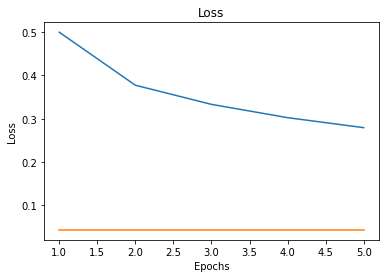

In [ ]:
import matplotlib.pyplot as plt

epch=[i for i in range(1,6)]

plt.plot(epch, losses,label='train')
plt.plot(epch,val_loss,label='val')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [ ]:
model.eval()
input_ids = tokenizer.encode(removeSpecial("11th_Mississippi_Infantry_Monument | country | United States && 11th_Mississippi_Infantry_Monument | location | Adams_County,_Pennsylvania && 11th_Mississippi_Infantry_Monument | state | Pennsylvania && 11th_Mississippi_Infantry_Monument | established | 2000 && 11th_Mississippi_Infantry_Monument | category | Contributing_property && 11th_Mississippi_Infantry_Monument | municipality | Gettysburg,_Pennsylvania</s>"), return_tensors="pt")
input_ids = input_ids.to(dev)
outputs = model.generate(input_ids, max_length=400, num_beams=5, early_stopping=True)
addSpecial(tokenizer.decode(outputs[0][1:-1]))


'The 11th Mississippi Infantry Monument is located in the municipality of Gettysburg, Adams County, Pennsylvania, USA. It was established in 2000 and is categorised as a contributing property. '

In [ ]:
model.eval()
input_ids = tokenizer.encode(removeSpecial("WebNLG: Mermaid_(Train_song) | recordLabel | Columbia_Records && Mermaid_(Train_song) | runtime | 3.16 && Mermaid_(Train_song) | recordLabel | Sony_Music_Entertainment && Mermaid_(Train_song) | writer | Espen_Lind && Mermaid_(Train_song) | genre | Reggae && Mermaid_(Train_song) | writer | Amund_Bjørklund </s>"), return_tensors="pt")
input_ids = input_ids.to(dev)
outputs = model.generate(input_ids, max_length=400, num_beams=5, early_stopping=True)
addSpecial(tokenizer.decode(outputs[0][1:-1]))


In [ ]:
model.eval()
input_ids = tokenizer.encode(removeSpecial('Allen_Forrest | birthYear | 1981 && Allen_Forrest | genre | Acoustic_music && Allen_Forrest | birthPlace | "Fort Campbell, KY, raised in Dothan, AL" && Allen_Forrest | background | "solo_singer" && Allen_Forrest | birthPlace | Fort_Campbell</s>'), return_tensors="pt")
input_ids = input_ids.to(dev)
outputs = model.generate(input_ids, max_length=400, num_beams=5, early_stopping=True)
addSpecial(tokenizer.decode(outputs[0][1:-1]))


'Allen Forrest was born in Fort Campbell, Kentucky in 1981. He plays acoustic music and has a background as a solo singer. '

In [ ]:
model.eval()
input_ids = tokenizer.encode(removeSpecial('Neymar | fullname | Neymar da Silva Santos Júnior && Neymar | country | Brazil && Neymar | city | São Paulo && Neymar | job | footballer </s>'), return_tensors = "pt")
input_ids = input_ids.to(dev)
outputs = model.generate(input_ids, max_length=400, num_beams=5, early_stopping=True)
addSpecial(tokenizer.decode(outputs[0][1:-1]))

'Neymar, whose full name is Neymar Da Silva Santos Júnior, is a footballer in São Paulo, Brazil. '

In [ ]:
model.eval()
l=[]
w=[]
for indx,row in test.iterrows():
  input=row['input_text']+' </s>'
  input_ids=tokenizer.encode(input, return_tensors="pt")
  input_ids=input_ids.to(dev)
  outputs = model.generate(input_ids, max_length=400, num_beams=4, early_stopping=True)
  x=addSpecial(tokenizer.decode(outputs[0][1:-1]))
  y=tokenizer.decode(outputs[0][1:-1])
  l.append(x)
  w.append(y)


In [ ]:
r= []
for indx,row in test.iterrows():
  r.append(row['input_text'])


In [ ]:
print(l)
print(len(l))
print(test.shape)

['Reşadiye was the birthplace of Nurhan Atasoy, who won the State Award for Superior Award. ', 'The Queen of England is the birthplace of Mary Anne Monson, who was born in the Kingdom of England in the Kingdom of England. NZ289147 is the reference number of the city. ', 'Let Let Breed is the sequel to the record label, love american style. ', 'The child of John McMills is called Juliat Miller. ', 'Alan Shepard was born in New Hampshire on November 18th, 1923. He died in California on the 1st of August, 1974. Hepard retired on the 1st of August, 1974. ', 'The Bedford Avenue, located in Thurleigh, serves the city of the city of Bedford. It is operated by Motor Sport Vision. ', 'AmeriGas works and provides its services in the United States, in the United States. ', 'The artist, The Veinvet Uderground, is the artist of the character Bootleg Série 1: The Quinet. The genre of the band is Proto-punk. ', 'The American band The Hornmoon Millers is the producer of the record label turn me on whi

In [ ]:
removedDup = {'input_text':[],'target_text':[]}
for i in range(len(l)):
  if r[i] not in removedDup['input_text']:
    removedDup['input_text'].append(r[i])
    removedDup['target_text'].append(w[i])

In [ ]:
print(len(removedDup['input_text']))
print(len(removedDup['target_text']))
print(removedDup)

1779
1779
{'input_text': ['Nurhan_Atasoy | birthPlace | Reşadiye && Nurhan_Atasoy | award | State_Award_for_Superior_Achievement', 'Lady_Anne_Monson | birthPlace | Darlington && Kingdom_of_England | dissolutionYear | 1707 && Darlington | gridReference | NZ289147 && Lady_Anne_Monson | birthPlace | Kingdom_of_England && Lady_Anne_Monson | nationality | Kingdom_of_England', 'Let_It_Breed | precededBy | Love_American_Style_(album)', 'John_Mills | child | Juliet_Mills', 'Alan_Shepard | birthDate | "1923-11-18" && Alan_Shepard | deathPlace | California && Alan_Shepard | dateOfRetirement | "1974-08-01" && Alan_Shepard | birthPlace | New_Hampshire', 'Bedford_Aerodrome | operatingOrganisation | MotorSport_Vision && Bedford_Aerodrome | cityServed | Bedford_Autodrome && Bedford_Aerodrome | location | Thurleigh', 'AmeriGas | regionServed | United_States && AmeriGas | country | United_States', 'Bootleg_Series_Volume_1:_The_Quine_Tapes | artist | The_Velvet_Underground && The_Velvet_Underground | ge

In [ ]:
rdf = pd.DataFrame(removedDup)
rdf.to_csv('removedDup.csv')

In [ ]:
dcCopy = dc.copy()
dcFixed = {}
for i in dcCopy['input_text']:
  if i not in dcFixed:
    dcFixed[i] = []

In [ ]:
for i in range(len(dcCopy['target_text'])):
  dcFixed[dcCopy['input_text'][i]].append(dcCopy['target_text'][i])

In [ ]:
#BlEU Score Evaluation
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
refs = []
hyp = []

for i in range(len(removedDup['input_text'])):
  hyp.append(removedDup['target_text'][i].split())
  re = dcFixed[removedDup['input_text'][i]]
  for x in range(len(re)):
    re[x] = list(re[x].split())
  refs.append(dcFixed[removedDup['input_text'][i]])

print(hyp[2])
print(refs[2])

['Let', 'Let', 'Breed', 'is', 'the', 'sequel', 'to', 'the', 'record', 'label,', 'love', 'american', 'style.']
[['The', 'album', 'Let', 'It', 'Breed', 'is', 'preceded', 'by', 'the', 'release', 'of', 'the', 'album', 'Love', 'American', 'Style.'], ['The', 'album', 'Let', 'It', 'Breed', 'was', 'preceded', 'by', 'the', 'release', 'of', 'the', 'Love', 'American', 'Style', 'album.'], ['Let', 'it', 'Breed', 'was', 'preceded', 'by', 'the', 'album', 'Love', 'American', 'Style.']]


In [ ]:
bleuscore = corpus_bleu(refs,hyp)
print(bleuscore)

0.3299413052750862
